<a href="https://colab.research.google.com/github/AnthonyAugust/Projetos-Finalizados/blob/main/Projeto_de_cria%C3%A7%C3%A3o_de_uma_base_de_dados_e_treinamento_da_rede_YOLO_(Menos_Imagens)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5/yolov5
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-08-26 14:08:44.372955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756217324.411543   25596 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756217324.423406   25596 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756217324.451809   25596 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.

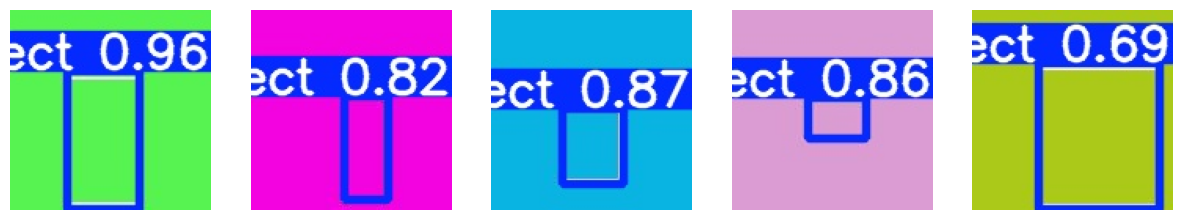

In [2]:
# 1 Instalar YOLOv5 e dependências
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -qr requirements.txt

import torch
from pathlib import Path
import os, random, shutil
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# 2 Criar dataset de teste com 5.000 imagens e labels YOLO fictícias
dataset_dir = Path("my_dataset")
train_img_dir = dataset_dir / "images/train"
val_img_dir   = dataset_dir / "images/val"
train_lbl_dir = dataset_dir / "labels/train"
val_lbl_dir   = dataset_dir / "labels/val"

for p in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
    p.mkdir(parents=True, exist_ok=True)

# Gerar imagens e labels
num_train = 4500
num_val = 500
img_size = 128

def create_image_and_label(idx, img_dir, lbl_dir):
    img = Image.new("RGB", (img_size, img_size), color=(random.randint(0,255), random.randint(0,255), random.randint(0,255)))
    draw = ImageDraw.Draw(img)

    # Criar retângulo aleatório para objeto
    x0, y0 = random.randint(0,64), random.randint(0,64)
    x1, y1 = random.randint(x0+10, 127), random.randint(y0+10, 127)
    draw.rectangle([x0, y0, x1, y1], outline="white", width=2)

    img_path = img_dir / f"{idx:05}.jpg"
    img.save(img_path)

    # Label YOLO: class_id, x_center, y_center, width, height (normalizado)
    x_center = ((x0 + x1)/2) / img_size
    y_center = ((y0 + y1)/2) / img_size
    w = (x1 - x0) / img_size
    h = (y1 - y0) / img_size

    lbl_path = lbl_dir / f"{idx:05}.txt"
    with open(lbl_path, "w") as f:
        f.write(f"0 {x_center} {y_center} {w} {h}\n")  # classe 0

for i in range(num_train):
    create_image_and_label(i, train_img_dir, train_lbl_dir)

for i in range(num_val):
    create_image_and_label(i, val_img_dir, val_lbl_dir)

# 3 Criar arquivo .yaml para YOLOv5
data_yaml = dataset_dir / "dataset.yaml"
with open(data_yaml, "w") as f:
    f.write(f"""
train: {train_img_dir.resolve()}
val: {val_img_dir.resolve()}

nc: 1
names: ['object']
""")

# 4 Treinar YOLOv5 pequeno (só para teste)
!python train.py --img 128 --batch 32 --epochs 5 --data {data_yaml} --weights yolov5s.pt --project runs/train_5k --name exp_5k

# 5 Detectar algumas imagens do conjunto de validação
!python detect.py --weights runs/train_5k/exp_5k/weights/best.pt --img 128 --source {val_img_dir} --conf 0.25 --save-txt --save-conf --project runs/detect_5k --name exp_5k_results

# 6 Mostrar 5 imagens detectadas
detect_dir = Path("runs/detect_5k/exp_5k_results")
detect_images = list(detect_dir.glob("*.jpg"))
plt.figure(figsize=(15,8))
for i, img_path in enumerate(detect_images[:5]):
    plt.subplot(1,5,i+1)
    plt.imshow(Image.open(img_path))
    plt.axis('off')
plt.show()